# Model quality - contact map


In [1]:
import os, sys
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import random
import time

mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/model_quality_contactmap'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#load the model
model = FHS.get_model()

In [5]:
#load pdb interactions
pdb_interactions = FHS.get_1xpb_interactions().dropna()

## Plot Contact Map

In [6]:
# select ECs that are at least 5 residues apart in primary sequence
longrange_ecs = model.ecs.query('abs(i - j) > 5')

#show ECs the top L (alignment length) ECs that are at least 5 residues
#apart in the primary sequence
show_ecs = longrange_ecs[:len(model.seq())].copy()

#add pdb position to the dataframe based on the model 
show_ecs = FHS.add_pdb_num_from_model_num(
    show_ecs, 'i', 'pdb_i'
)
show_ecs = FHS.add_pdb_num_from_model_num(
    show_ecs, 'j', 'pdb_j'
)

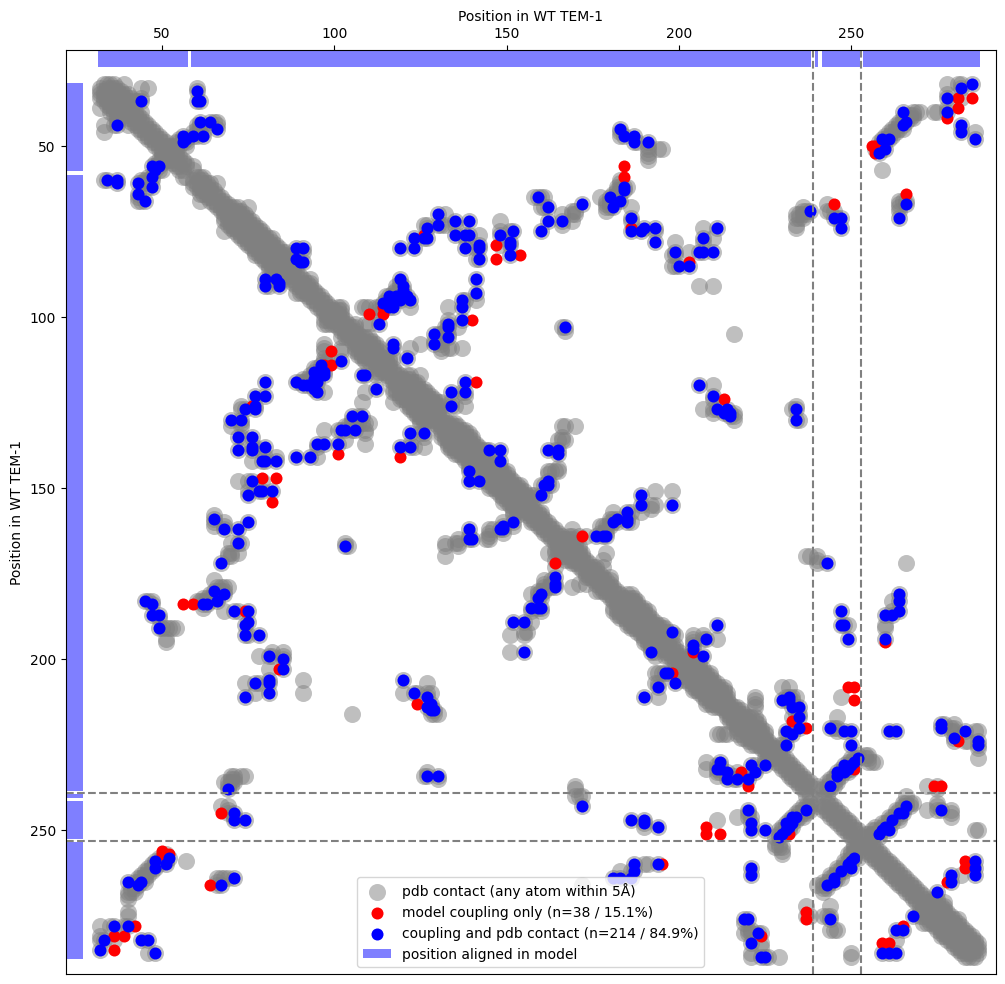

In [7]:
fig, ax = plt.subplots(1, 1)#, gridspec_kw={'height_ratios': [15, 1]}, sharex=True)
fig.set_size_inches(12, 12)

shared_interactions = pd.merge(
    show_ecs, pdb_interactions, how ='inner', 
    left_on=['i', 'j', 'pdb_i', 'pdb_j'], 
    right_on=['model_i', 'model_j', 'pdb_i', 'pdb_j']
).sort_values(by=['i','j'])

#pull out interactions not found in pdb
model_exclusive_interactions = show_ecs.merge(
    shared_interactions, indicator=True, how='outer'
)
model_exclusive_interactions = model_exclusive_interactions[
    model_exclusive_interactions['_merge'] == 'left_only'
]

#plot background
sns.scatterplot(
    data=pdb_interactions, 
    x='pdb_i', y='pdb_j', 
    label='pdb contact (any atom within 5Å)',
    color='gray', alpha=.5, linewidth=0, s=150,
    ax=ax, 
)
sns.scatterplot(
    data=pdb_interactions, 
    x='pdb_j', y='pdb_i', 
    color='gray', alpha=.5, linewidth=0, s=150,
    ax=ax, 
)

#plot false positives
sns.scatterplot(
    data=model_exclusive_interactions, 
    x='pdb_i', y='pdb_j', 
    label='model coupling only (n={0} / {1:.1f}%)'.format(
        len(model_exclusive_interactions),
        len(model_exclusive_interactions) / len(show_ecs) * 100
    ), 
    color='red', linewidth=0, s=75,
    ax=ax, 
)
sns.scatterplot(
    data=model_exclusive_interactions, 
    x='pdb_j', y='pdb_i', 
    color='red', linewidth=0, s=75,
    ax=ax, 
)

#plot overlapping pdb contacts with top ecs
sns.scatterplot(
    data=shared_interactions, 
    x='pdb_i', y='pdb_j', 
    label='coupling and pdb contact (n={0} / {1:.1f}%)'.format(
        len(shared_interactions),
        len(shared_interactions) / len(show_ecs) * 100
    ),
    color='blue', linewidth=0, s=75,
    ax=ax, 
)
sns.scatterplot(
    data=shared_interactions, 
    x='pdb_j', y='pdb_i', 
    color='blue', linewidth=0, s=75,
    ax=ax, 
)

min = np.min([np.min(pdb_interactions.pdb_i), np.min(pdb_interactions.pdb_j)])
max = np.max([np.max(pdb_interactions.pdb_i), np.max(pdb_interactions.pdb_j)])

#plot unaligned positions
unaligned_model_positions=[]
aligned_model_positions=[]
position_numbering = FHS.get_numbering_df()
aligned_in_model_pdbpositions = position_numbering[
    ~position_numbering.model_num.isna()
].pdb_num

ax.bar(
    x=aligned_in_model_pdbpositions,
    height=min-5, width=1, color='blue', alpha=0.5,
    label='position aligned in model'
)
ax.barh(
    aligned_in_model_pdbpositions, 
    min-5, height=1, color='blue', alpha=0.5,
)

#indicate position numbers not included in pdb
position_numbers_not_in_pdb = np.setxor1d(
    [idx for idx in range(
        np.min(position_numbering.pdb_num), np.max(position_numbering.pdb_num)+1, 
    )], 
    position_numbering.pdb_num
)
for pos_num in position_numbers_not_in_pdb:
    ax.axvline(pos_num, color='gray', linestyle='--')
    ax.axhline(pos_num, color='gray', linestyle='--')

ax.set_xlim(min-10, max+5)
ax.set_ylim(min-10, max+5)
ax.set_ylabel('Position in WT TEM-1') 
ax.set_xlabel('Position in WT TEM-1') 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.legend()
plt.gca().invert_yaxis()

fig.savefig(OUTPUT_DIR+'/model_contactmap.pdf')

## Output Source Data

In [8]:
def get_source_pdbinteraction_data():
    return pdb_interactions.assign(
        pos1 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.pdb_i_aa, r.pdb_i),
            axis = 'columns'
        ),
        pos2 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.pdb_j_aa, r.pdb_j),
            axis = 'columns'
        )
    )[[
        'pos1', 'pos2', 'min_atom_distance'
    ]].rename(columns={
        'pos1': 'Position 1 (PDB: 1XPB)', 
        'pos2': 'Position 2 (PDB: 1XPB)', 
        'min_atom_distance': 'Minimum Atom Distance (A)'
    })
get_source_pdbinteraction_data().to_csv(
    OUTPUT_DIR+'/pdb_interactions.tab', sep ='\t', index=False
)

In [9]:
def get_source_model_exclusive_interactions():
    return model_exclusive_interactions.assign(
        pos1 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.A_i, r.pdb_i),
            axis = 'columns'
        ),
        pos2 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.A_j, r.pdb_j),
            axis = 'columns'
        )
    )[[
        'pos1', 'pos2', 'cn'
    ]].rename(columns={
        'pos1': 'Position 1 (PDB: 1XPB)', 
        'pos2': 'Position 2 (PDB: 1XPB)', 
        'cn': 'Coupling Score'
    })
get_source_model_exclusive_interactions().to_csv(
    OUTPUT_DIR+'/model_exclusive_interactions.tab', sep ='\t', index=False
)

In [10]:
def get_source_shared_interactions():
    return shared_interactions.assign(
        pos1 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.A_i, r.pdb_i),
            axis = 'columns'
        ),
        pos2 = lambda df: df.apply(
            lambda r: '{0}{1}'.format(r.A_j, r.pdb_j),
            axis = 'columns'
        )
    )[[
        'pos1', 'pos2', 'min_atom_distance', 'cn', 
    ]].rename(columns={
        'pos1': 'Position 1 (PDB: 1XPB)', 
        'pos2': 'Position 2 (PDB: 1XPB)', 
        'min_atom_distance': 'Minimum Atom Distance (A)',
        'cn': 'Coupling Score'
    })
get_source_shared_interactions().to_csv(
    OUTPUT_DIR+'/model_pdb_shared_interactions.tab', sep ='\t', index=False
)